# Start zookeeper and kafka server

Standard procedure operate in shell

### 1.start zookeeper
bin/zookeeper-server-start.sh config/zookeeper.properties

### 2.start kafka server
bin/kafka-server-start.sh config/server.properties

### 3.create topic test
bin/kafka-topics.sh --create --zookeeper localhost:2181 --replication-factor 1 --partitions 1 --topic test

### 4.create producer
bin/kafka-console-producer.sh --broker-list localhost:9092 --topic test

txt here

### 5.create consumer
bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic test --from-beginning

### 6.Check topic
bin/kafka-topics.sh --list --zookeeper localhost:2181

# Run kafka python locally 
We create a shell producer and a python producer. Consumer print out every thing on the topic "python_test_0".
![image](shell_producer.png)

In [15]:
from kafka import KafkaConsumer,KafkaProducer
topic_1='python_test_0'

def producer(topic):
    producer = KafkaProducer(bootstrap_servers='localhost:9092')
    for i in range(5):
        producer.send(topic, b'this massage is coming from python %i' %i).get(timeout=30)
    

def consumer(topic):
    # get every massage from the beginning on localhost 9092 within 1 sec
    consumer = KafkaConsumer(bootstrap_servers='localhost:9092',
                                 auto_offset_reset='earliest',
                                 consumer_timeout_ms=1000)
    consumer.subscribe(topic)
    
    for message in consumer:
        
        print ("%s:%d:%d: key=%s,value=%s" % (message.topic, message.partition,\
                                              message.offset, message.key,message.value))

    consumer.close()

In [49]:
#send massage from python 
producer(topic_1)

In [51]:
#recieve massage from two producers
consumer(topic_1)

python_test_0:0:0: key=None,value=this massage is coming from python 0
python_test_0:0:1: key=None,value=this massage is coming from python 1
python_test_0:0:2: key=None,value=this massage is coming from python 2
python_test_0:0:3: key=None,value=this massage is coming from python 3
python_test_0:0:4: key=None,value=this massage is coming from python 4
python_test_0:0:5: key=None,value=this massage is comming from shell 0
python_test_0:0:6: key=None,value=this massage is comming from shell 1
python_test_0:0:7: key=None,value=this massage is comming from shell 2


# Run kafka python on twitter
1. Get twitter streaming data with keyword
2. Use producer send data to kafka server 
3. Create consumer to recive data from kafka server
4. Put data into pandas data frame and do wordcount or other text mining from here. 


In [6]:
from kafka import KafkaConsumer,KafkaProducer
import json
#import sentiment_mod as s
#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream,API
from kafka import KafkaConsumer,KafkaProducer
import time

topic_2='tweepy_test_0'
producer = KafkaProducer(bootstrap_servers='localhost:9092')
#Variables that contains the user credentials to access Twitter API 
access_token = "XXXXX"
access_token_secret = "XXXXX"
consumer_key = "XXXX"
consumer_secret = "XXXXX"


#This is a basic listener that just prints received tweets to stdout.
class myListener(StreamListener):
    def __init__(self, time_limit=60):
        self.start_time = time.time()
        self.limit = time_limit
        
    def on_data(self, data):
        time_now=time.time() - self.start_time
        if time_now < self.limit:
            #print data
            producer.send(topic_2, data.encode('utf-8'))
            return True
        else:
            print 'stop tweepy streaming'
            return False

    def on_error(self, status):
        print status


if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = myListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    myStream = Stream(auth, listener=myListener(time_limit=2))
    keyword=['tax','Democrats']
    #This line filter Twitter Streams to capture data by the keywords
    myStream.filter(track=keyword)

stop tweepy streaming


In [8]:
import pandas as pd
consumer = KafkaConsumer(bootstrap_servers='localhost:9092',
                                 auto_offset_reset='earliest',
                                 consumer_timeout_ms=1000)
consumer.subscribe(topic_2)

tweet=pd.DataFrame()
tweet_text=[]
tweet_lang=[]
for msg in consumer:
    all_data = json.loads(msg.value)
    #print all_data["text"]
    tweet_text.append(all_data["text"])
    tweet_lang.append(all_data["lang"])


tweet['text']=tweet_text
tweet['lang']=tweet_lang
tweet.head(20)

,text,lang
0,RT @owillis: 10 gop president elected\n20 enac...,en
1,"RT @sunnyherring1: #MikeHuckabee=\n ""NONE OF U...",en
2,RT @chuckwoolery: This whole #FISAMemoRelease ...,en
3,"RT @RogueSNRadvisor: ""I want transparency so I...",en
4,RT @RAM0667: Liberals even deny facts proven b...,en
5,RT @GrantDCostello: 🕰️ A history of @RuthDavi...,en
6,RT @PressSec: When Obama was President and Dem...,en
7,RT @Lrihendry: An oath means nothing to Democr...,en
8,RT @Jamfan03: @JoeTalkShow My company (Best Bu...,en
9,RT @mitchellvii: After freaking out for two we...,en


In [10]:

def word_in_sen(word, text):
    word=word.lower()
    text=text.lower()
    if word in text:
        return True
    else:
        return False

tweet['tax'] = tweet['text'].apply(lambda x: word_in_sen('tax', x))
tweet['Democrats'] = tweet['text'].apply(lambda x: word_in_sen('Democrats', x))
tweet.shape

(14, 5)

In [12]:
print tweet['tax'].groupby(tweet['tax']).count()
print tweet['tax'].groupby(tweet['Democrats']).count()

tax
False    10
True      4
Name: tax, dtype: int64
Democrats
False    8
True     6
Name: tax, dtype: int64


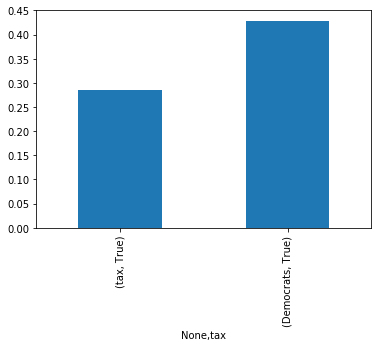

In [33]:
import matplotlib.pyplot as plt
import matplotlib
total=tweet.shape[0]
tax_c=tweet[tweet.tax==True]['text'].groupby(tweet['tax']).count()/total
D_c=tweet[tweet.Democrats==True]['text'].groupby(tweet['Democrats']).count()/total
pd.concat([tax_c, D_c], axis=0,keys=['tax','Democrats']).plot(kind='bar');

# Furure work
1. Text mining 
2. Integrate kafka with spark

# Reference
1.https://kafka.apache.org/quickstart
2.